In [2]:
"""
CART Implementation for Class Imbalance Study

Original Reference Implementation:
- Adapted from zziz/cart (https://github.com/zziz/cart)
- Clean-room implementation without direct code copying

Key Modifications from Reference:
1. Architecture Simplification:
   - Removed regression functionality to focus purely on classification
   - Unified tree structure with dedicated TreeNode class
   - Simplified API (removed pruning parameters, consolidated initialization)

2. Project-Specific Optimizations:
   - Direct compatibility with preprocessed numpy arrays (from data/processed/)
   - Binary classification focus with class label tracking
   - Early stopping criteria aligned with imbalance analysis needs
   - Memory-efficient node structure for large datasets

3. Phase 2 Readiness:
   - Modular impurity calculations for weighted Gini modification
   - Class label preservation for imbalance weighting
   - Predict method optimized for probability-based metrics (ROC-AUC)

Implementation Differences from Reference:
- No sklearn dependencies
- Removed print_tree visualization methods
- Simplified split criteria to essential parameters
- Vectorized impurity calculations for performance
- Added sample counting for imbalance analysis

Important Notes:
- Designed for binary classification (handles multi-class through majority voting)
- Requires preprocessed numerical features (compatible with utils/preprocess.py)
- Class labels stored in self.classes for Phase 2 modifications

Maintains Core CART Functionality:
- Gini/Entropy split criteria
- Depth-based stopping
- Recursive tree construction
- Majority class prediction
"""

'\nCART Implementation for Class Imbalance Study\n\nOriginal Reference Implementation:\n- Adapted from zziz/cart (https://github.com/zziz/cart)\n- Clean-room implementation without direct code copying\n\nKey Modifications from Reference:\n1. Architecture Simplification:\n   - Removed regression functionality to focus purely on classification\n   - Unified tree structure with dedicated TreeNode class\n   - Simplified API (removed pruning parameters, consolidated initialization)\n\n2. Project-Specific Optimizations:\n   - Direct compatibility with preprocessed numpy arrays (from data/processed/)\n   - Binary classification focus with class label tracking\n   - Early stopping criteria aligned with imbalance analysis needs\n   - Memory-efficient node structure for large datasets\n\n3. Phase 2 Readiness:\n   - Modular impurity calculations for weighted Gini modification\n   - Class label preservation for imbalance weighting\n   - Predict method optimized for probability-based metrics (ROC-A

Since there was so much data missing from the datasets, whether it was a row with many NaN (Not a Number) values or a column with the same issue, we thought the best way to solve that was to preprocess the datasets' data. So we came up with the following program, which reads the data first (in data/raw) and then processes them. Then, it inserts the processed data into the data/processed directory, where the trained and tested data are all separated in different files (X_train.csv, X_test.csv, y_train.csv, y_test.csv).

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


def preprocess_datasets(
    raw_dir="data/raw/class_imbalance",
    processed_dir="data/processed/class_imbalance",
    test_size=0.3,
    random_state=42,
):
    """
    Preprocess datasets with robust label encoding and validation
    """
    os.makedirs(processed_dir, exist_ok=True)
    label_encoder = LabelEncoder()

    for filename in os.listdir(raw_dir):
        if not filename.endswith(".csv"):
            continue

        print(f"{processed_dir}:")
        print(f"Processing {filename}...")
        file_path = os.path.join(raw_dir, filename)

        try:
            # Load and validate data
            df = pd.read_csv(file_path)
            if df.shape[1] < 2:
                print(f"Skipping {filename}: Insufficient columns")
                continue

            # Separate features and target
            X = df.iloc[:, :-1].copy()
            y_raw = df.iloc[:, -1].copy()

            # Clean and encode labels
            valid_mask = y_raw.notna()
            X, y_raw = X[valid_mask], y_raw[valid_mask]
            y_raw_sorted = np.sort(y_raw)
            if len(y_raw_sorted) == 0:
                print(f"Skipping {filename}: No valid targets")
                continue

            # Convert labels to 0-indexed integers
            y = pd.Series(label_encoder.fit_transform(y_raw_sorted), name=y_raw.name)
            classes = label_encoder.classes_
            if len(classes) < 2:
                print(f"Skipping {filename}: Only one class present")
                continue

            # Numerical imputation
            num_cols = X.select_dtypes(include=np.number).columns
            if len(num_cols) > 0:
                X[num_cols] = X[num_cols].fillna(X[num_cols].mean()).fillna(0)

            # Categorical imputation
            cat_cols = X.select_dtypes(exclude=np.number).columns
            for col in cat_cols:
                mode = X[col].mode()[0] if not X[col].mode().empty else "missing"
                X[col] = X[col].fillna(mode)

            # Convert categoricals to dummies
            if len(cat_cols) > 0:
                X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

            # Final validation
            X = X.fillna(0).infer_objects()
            assert not X.isna().any().any(), "NaN values in features"
            assert X.shape[0] > 0, "Empty dataset after preprocessing"

            # Normalize numericals
            num_cols = X.select_dtypes(include=np.number).columns
            if len(num_cols) > 0:
                X[num_cols] = MinMaxScaler().fit_transform(X[num_cols])

            # Stratified split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, stratify=y, random_state=random_state
            )

            # Save processed data
            base_name = os.path.splitext(filename)[0]
            output_dir = os.path.join(processed_dir, base_name)
            os.makedirs(output_dir, exist_ok=True)

            X_train.to_csv(os.path.join(output_dir, "X_train.csv"), index=False)
            X_test.to_csv(os.path.join(output_dir, "X_test.csv"), index=False)
            y_train.to_csv(os.path.join(output_dir, "y_train.csv"), index=False)
            y_test.to_csv(os.path.join(output_dir, "y_test.csv"), index=False)

            print(f"Classes: {list(classes)} → {list(y.unique())}\n")

        except Exception as e:
            print(f"Failed processing {filename}: {str(e)}\n")


if __name__ == "__main__":
    preprocess_datasets()

data/processed/class_imbalance:
Processing dataset_978_mfeat-factors.csv...
Classes: ['N', 'P'] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_947_arsenic-male-bladder.csv...
Classes: ['N', 'P'] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_1004_synthetic_control.csv...
Classes: ['N', 'P'] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_1056_mc1.csv...
Classes: [np.False_, np.True_] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_940_water-treatment.csv...
Classes: ['N', 'P'] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_950_arsenic-female-lung.csv...
Classes: ['N', 'P'] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_1014_analcatdata_dmft.csv...
Classes: ['N', 'P'] → [np.int64(0), np.int64(1)]

data/processed/class_imbalance:
Processing dataset_1039_hiva_agnostic.csv...
Classes: [np.in

Unlike the code that inspired our work (zziz/cart), our CART version has more than one class. It has two: one for the tree node (TreeNode) and the other for CART itself (DecisionTree).

In [4]:
import numpy as np

class TreeNode:
    """Node structure for decision tree"""

    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Feature index for splitting
        self.threshold = threshold  # Threshold value for split
        self.left = left  # Left subtree
        self.right = right  # Right subtree
        self.value = value  # Class label for leaf nodes
        self.samples = 0  # Number of samples in node
        self.depth = 0  # Depth in tree structure

In [5]:
class DecisionTree:
    """CART classifier with Gini/Entropy criteria for handling class imbalance analysis"""

    def __init__(self, max_depth=None, min_samples_split=2, criterion="gini"):
        self.max_depth = max_depth  # Maximum tree depth
        self.min_samples_split = min_samples_split  # Minimum samples to split
        self.criterion = criterion.lower()  # Impurity measure (gini/entropy)
        self.root = None  # Root node of decision tree
        self.classes = None  # Store class labels

    def fit(self, X, y):
        """Build decision tree from training data."""
        y = self._convert_labels(y)
        self.classes = np.unique(y)
        self.root = self._grow_tree(X, y, depth=0)

    def predict(self, X):
        """Predict class labels for input samples"""
        return np.array([self._traverse(x, self.root) for x in X])

    def _convert_labels(self, y):
        """Convert labels to np.int64. If conversion fails, map categorical labels to numbers."""
        try:
            return y.astype(np.int64)
        except ValueError:
            uniques = np.unique(y)
            mapping = {label: idx for idx, label in enumerate(uniques)}
            return np.array([mapping[val] for val in y], dtype=np.int64)

    def _grow_tree(self, X, y, depth):
        """Recursively build decision tree"""
        node = TreeNode()
        node.samples = X.shape[0]
        node.depth = depth

        # Stopping conditions
        if (
            (self.max_depth and depth >= self.max_depth)
            or (node.samples < self.min_samples_split)
            or (len(np.unique(y)) == 1)
        ):
            node.value = self._most_common(y)
            return node

        # Find optimal split
        feature, threshold = self._best_split(X, y)
        if feature is None:
            node.value = self._most_common(y)
            return node

        # Split dataset
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx

        # Grow child nodes
        node.feature = feature
        node.threshold = threshold
        node.left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        node.right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return node

    def _best_split(self, X, y):
        """Find optimal feature and threshold for splitting"""
        best_gain = -1
        best_feature, best_threshold = None, None
        current_impurity = self._calculate_impurity(y)

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_y = y[X[:, feature] <= threshold]
                right_y = y[X[:, feature] > threshold]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                gain = current_impurity - self._weighted_impurity(left_y, right_y)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_impurity(self, y):
        """Calculate impurity of target values"""
        proportions = np.bincount(y) / len(y)

        if self.criterion == "gini":
            return 1 - np.sum(proportions**2)
        elif self.criterion == "entropy":
            return -np.sum(proportions * np.log2(proportions))
        else:
            raise ValueError("Invalid criterion. Use 'gini' or 'entropy'")

    def _weighted_impurity(self, left_y, right_y):
        """Calculate weighted impurity for child nodes"""
        n_left, n_right = len(left_y), len(right_y)
        n_total = n_left + n_right

        return (n_left / n_total) * self._calculate_impurity(left_y) + (
            n_right / n_total
        ) * self._calculate_impurity(right_y)

    def _most_common(self, y):
        """Find majority class label"""
        return np.bincount(y).argmax()

    def _traverse(self, x, node):
        """Traverse tree to make prediction"""
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)

### File evaluation.py

In [10]:
from sklearn.metrics import f1_score, roc_auc_score

base_dir = "data/processed/class_imbalance"
results = {}
for dataset in os.listdir(base_dir):
    results[dataset] = []
    dataset_path = os.path.join(base_dir, dataset)
    # Load preprocessed data
    X_train = pd.read_csv(os.path.join(dataset_path, "X_train.csv")).values
    y_train = pd.read_csv(os.path.join(dataset_path, "y_train.csv")).values.flatten()

    # Initialize and train model
    tree = DecisionTree(max_depth=5, criterion="gini")   # Hyperparameter Tuning
    tree.fit(X_train, y_train)

    # Make predictions
    X_test = pd.read_csv(os.path.join(dataset_path, "X_test.csv")).values
    predictions = tree.predict(X_test)
    y_test = pd.read_csv(os.path.join(dataset_path, "y_test.csv")).values.flatten()
    accuracy = np.mean(predictions == y_test)
    f1 = f1_score(y_test, predictions)
    roc = roc_auc_score(y_test, predictions)
    results[dataset].append(accuracy)
    results[dataset].append(f1)
    results[dataset].append(roc)


### Empricial evaluation

In [12]:
results_df = pd.DataFrame.from_dict(results, orient='Index',columns=['Accuracy', 'F1-score', 'ROC'])
results_df

,Accuracy,F1-score,ROC
dataset_995_mfeat-zernike,0.873333,0.486486,0.751852
dataset_875_analcatdata_chlamydia,1.000000,1.000000,1.000000
dataset_1061_ar4,0.696970,0.285714,0.555556
dataset_1020_mfeat-karhunen,0.943333,0.725806,0.857407
dataset_966_analcatdata_halloffame,0.900498,0.947644,0.497253
dataset_765_analcatdata_apnea2,1.000000,1.000000,1.000000
dataset_1065_kc3,0.869565,0.000000,0.480000
dataset_984_analcatdata_draft,0.990909,0.947368,0.950000
dataset_968_analcatdata_birthday,0.981818,0.941176,0.989362
dataset_1021_page-blocks,0.899513,0.946757,0.527387


In [19]:
import matplotlib.pyplot as plt 

def plot(results,metric='Accuracy'):
    fig, ax = plt.subplots()
    ax.boxplot(results)
    ax.set_xticklabels(results.columns)
    ax.set_ylabel(metric)
    plt.show()

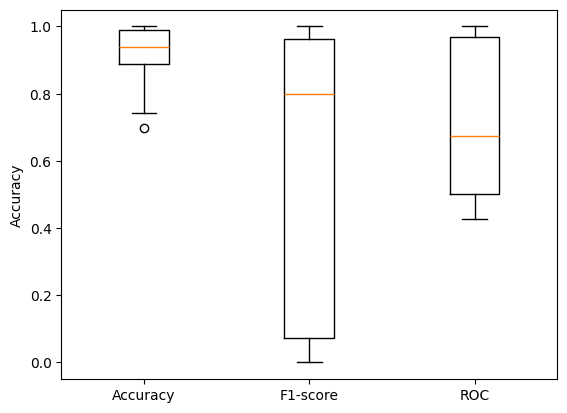

In [20]:
plot(results_df)

In [17]:
def plot_estimates(results,metric='Accuracy'):
    fig, ax = plt.subplots()
    ax.bar(results.columns, results.mean(), \
           yerr=results.std() / np.sqrt(results.shape[0]), \
                 capsize=5)
    ax.set_ylabel(metric)
    ax.set_title('Cross-validation results for multiple algorithms in a single task')
    plt.show()


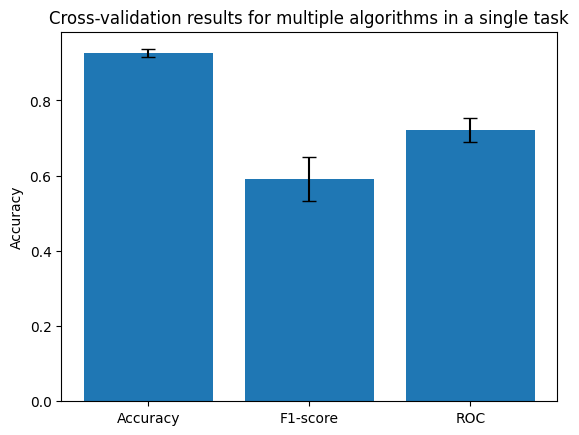

In [18]:
plot_estimates(results_df)

In [25]:
import scipy.stats as ss 

def plot_stat(results,baseline=None,stat_test="ttest",alpha=0.05,metric='Accuracy'):
    
    if baseline is None:
        baseline=results.columns[0]
       
    baseline_res = results[baseline]
        
    other_res = results.drop(baseline,axis=1)
    
    fig, ax = plt.subplots()
    ax.bar(baseline,baseline_res.mean(), \
           yerr=baseline_res.std() / np.sqrt(baseline_res.shape[0]), \
                 capsize=5,color="grey")
    
    cols = []
    for alg in other_res:
        # Compute the statistical significance of each algorithm with respect to the baseline using a paired t-test
        if stat_test == 'ttest':
            test_stat, test_p = ss.ttest_rel(other_res[alg], baseline_res)
        elif stat_test == 'wilcoxon':
            test_stat, test_p = ss.wilcoxon(other_res[alg],baseline_res,method='approx')
        if test_p < alpha:
            cols = cols + ['orange']
        else:
            cols = cols + ['blue']
    
    ax.bar(other_res.columns, other_res.mean(), \
           yerr=other_res.std() / np.sqrt(other_res.shape[0]), \
                 capsize=5,color=cols)

    ax.set_ylabel(metric)
    plt.show()

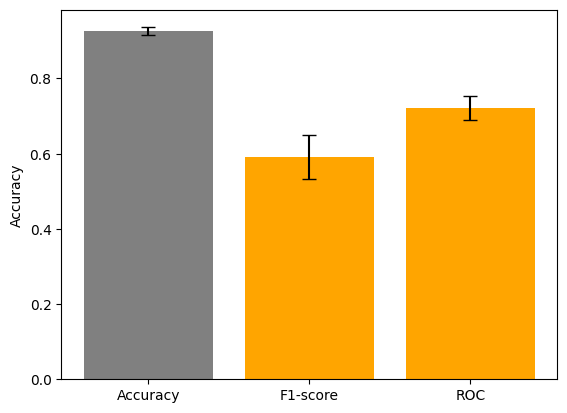

In [26]:
plot_stat(results_df, stat_test="ttest")

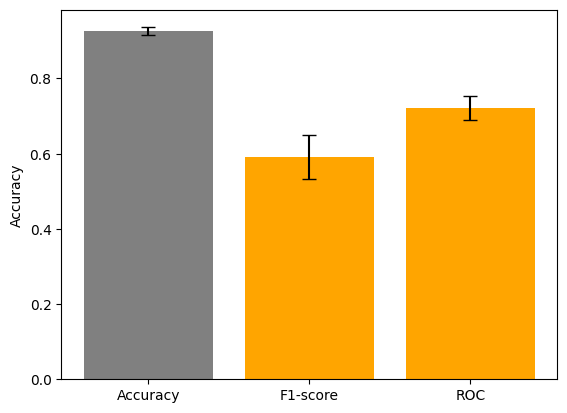

In [27]:
plot_stat(results_df, stat_test="wilcoxon")

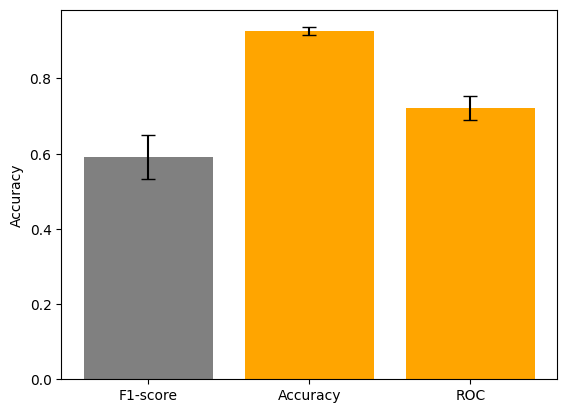

In [28]:
plot_stat(results_df, baseline="F1-score")

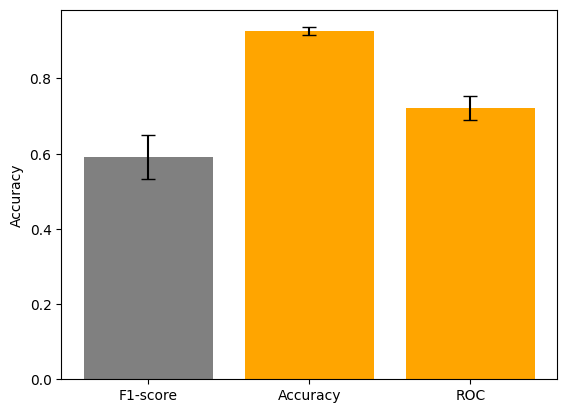

In [30]:
plot_stat(results_df, baseline="F1-score",stat_test="wilcoxon")

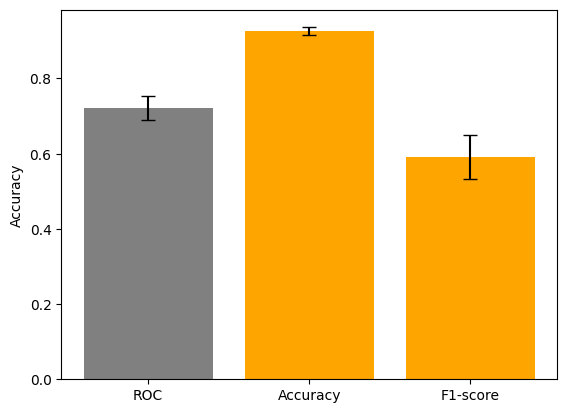

In [29]:
plot_stat(results_df, baseline="ROC")

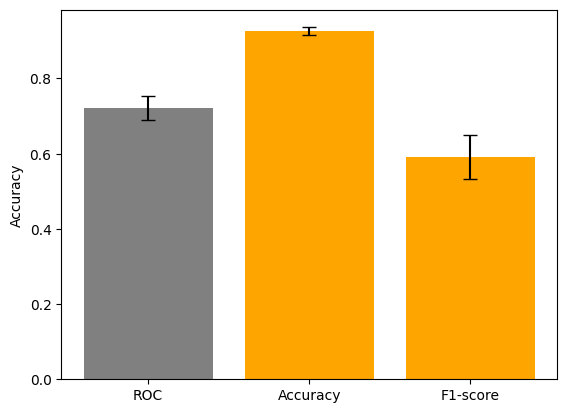

In [31]:
plot_stat(results_df, baseline="ROC", stat_test="wilcoxon")